In [819]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from pynq import allocate

In [820]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file

In [821]:
N = 8192
num_width = 32

In [822]:
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

In [823]:
def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

In [824]:
def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos

In [825]:
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [826]:
def reverse_bits(twos, num_bits):
    reversed_num = 0
    for i in range(num_bits):
        current_bit = (twos >> i) & 1
        reversed_num = (reversed_num << 1) | current_bit
    return reversed_num

In [827]:
dma_0 = ol.axi_dma_0
dma_1 = ol.axi_dma_1

In [828]:
iq_data = allocate(N, dtype=np.uint32)
for i in range(N):
#     iq_data[i] = get_value_from_complex(np.cos(i*2*np.pi/N) * 0x3FFF, np.sin(i*2*np.pi/N) * 0x3FFF, 16)
#     iq_data[i] = get_value_from_complex(0x7FFF, 0, 16) if i == 0 else 0
#     iq_data[i] = 0x1FFF0000
    iq_data[i] = get_value_from_complex(np.random.randint(-0x7FFF, , np.sin(i*2*np.pi/N) * 0x3FFF, 16)
res_data = allocate(N, dtype=np.uint64)

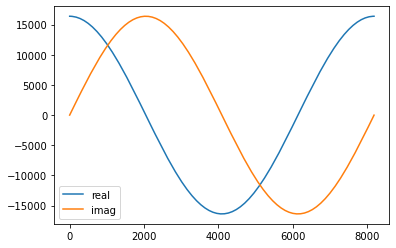

In [829]:
iq_data_components = get_components(iq_data, 16)
plt.plot(list(range(N)), iq_data_components['real'], label='real')
plt.plot(list(range(N)), iq_data_components['imag'], label='imag')
plt.legend()

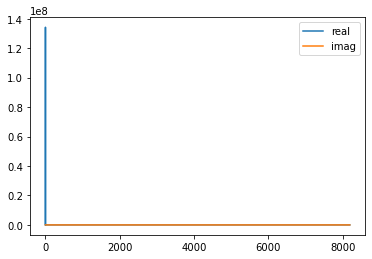

In [830]:
iq_fft = np.fft.fft(iq_data_components['real'] + iq_data_components['imag']*1j)
plt.plot(list(range(N)), iq_fft.real, label='real')
plt.plot(list(range(N)), iq_fft.imag, label='imag')
plt.legend()

In [841]:
# send configs to ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0

In [842]:
dma_1.sendchannel.transfer(fft_config)
dma_1.sendchannel.wait()

In [843]:
dma_0.sendchannel.transfer(iq_data)
dma_0.sendchannel.wait()

In [844]:
dma_0.recvchannel.transfer(res_data)
dma_0.recvchannel.wait()

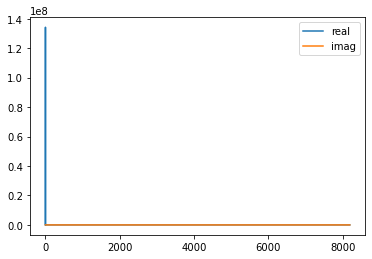

In [845]:
components = get_components(res_data, 32)
plt.plot(list(range(N)), components['real'], label='real')
plt.plot(list(range(N)), components['imag'], label='imag')
plt.legend()

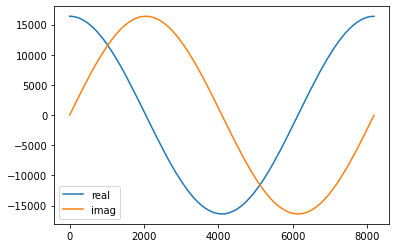

In [846]:
proposed_inputs = np.fft.ifft(components['real'] + components['imag']*1j)
plt.plot(list(range(N)), proposed_inputs.real, label='real')
plt.plot(list(range(N)), proposed_inputs.imag, label='imag')
plt.legend()